In [1]:
# Import required libraries for optimization, data processing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json

In [2]:
##Define the data folder path
folder_path = './data/question_1a'
file_type = ".json"

with open(f'{folder_path}/appliance_params{file_type}', 'r') as f:
    appliance_params = json.load(f)

with open(f'{folder_path}/bus_params{file_type}', 'r') as f:
    bus_params = json.load(f)

with open(f'{folder_path}/consumer_params{file_type}', 'r') as f:
    consumer_params = json.load(f)

with open(f'{folder_path}/DER_production{file_type}', 'r') as f:
    DER_production = json.load(f)

with open(f'{folder_path}/usage_preference{file_type}', 'r') as f:
    usage_preference = json.load(f)


In [3]:
# System Parameters
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']
tau_exp = bus_data['export_tariff_DKK/kWh']
max_import = bus_data['max_import_kW']
max_export = bus_data['max_export_kW']
electricity_prices = bus_data['energy_price_DKK_per_kWh']

In [4]:
#pv parameters
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']
pv_profile = DER_production[0]['hourly_profile_ratio']
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile]  #PV production per hour (kW)

In [5]:
## Load parameters
load_data = appliance_params['load'][0]
E_min = usage_preference[0]['load_preferences'][0]['min_total_energy_per_day_hour_equivalent'] #Minimum daily consumption (kWh)
max_load_per_hour = load_data['max_load_kWh_per_hour']  # maximum load per hour (kW)

In [6]:
# Temporal parameters
# Define the time horizon for optimization (24 hours in a day)
T = len(electricity_prices)  # Number of time periods (24 hours)
Times = range(T)  # Time index: 0 to 23

In [7]:
# Create Gurobi optimization model
# This model optimizes energy scheduling to minimize costs while meeting load requirements
model = gp.Model("Energy_Optimization")

# Decision variables
# Each variable is defined for every hour of the day (Times)
D_t = model.addVars(Times, lb=0, name="D_t")  # Load consumption (kW)
C_t = model.addVars(Times, lb=0, name="C_t")  # Energy curtailed from PV (kW)
P_imp_t = model.addVars(Times, lb=0, ub=max_import, name="P_imp_t")  # Grid import (kW)
P_exp_t = model.addVars(Times, lb=0, ub=max_export, name="P_exp_t")  # Grid export (kW)

Set parameter Username
Set parameter LicenseID to value 2617496
Set parameter LicenseID to value 2617496


Academic license - for non-commercial use only - expires 2026-02-03


## Mathematical Formulation

### Objective Function

$$
\min \sum_{t \in T} \left[ P_{imp,t} \cdot (\tau_{imp} + \lambda_t) - P_{exp,t} \cdot (lambda_t - \tau_{exp}) \right]
$$

Where:
- $P_{imp,t}$: Grid import at time $t$ (kW)
- $P_{exp,t}$: Grid export at time $t$ (kW)
- $\tau_{imp}$: Import tariff (DKK/kWh)
- $\tau_{exp}$: Export tariff (DKK/kWh)
- $\lambda_t$: Electricity price at time $t$ (DKK/kWh)

### Decision Variables

- $D_t \geq 0$: Load consumption at time $t$ (kW)
- $C_t \geq 0$: PV curtailment at time $t$ (kW)
- $P_{imp,t} \in [0, G_{imp,max}]$: Grid import at time $t$ (kW)
- $P_{exp,t} \in [0, G_{exp,max}]$: Grid export at time $t$ (kW)

### Constraints

**1. Power Balance:**
$$P_{imp,t} - P_{exp,t} = D_t - P^{PV}_t + C_t, \quad \forall t \in T$$

**2. PV Curtailment Limit:**
$$C_t \leq P^{PV}_t, \quad \forall t \in T$$

**3. Minimum Daily Energy Requirement:**
$$\sum_{t \in T} D_t \geq E_{min}$$

**4. Maximum Hourly Load:**
$$D_t \leq D_{max}, \quad \forall t \in T$$

**5. Variable Bounds:**
- $0 \leq D_t$
- $0 \leq P_{imp,t} \leq P_{imp,max}$
- $0 \leq P_{exp,t} \leq P_{exp,max}$
- $C_t \geq 0$

### Notes
- This is an **LP formulation** (binary import/export constraints omitted for computational efficiency)
- The objective minimizes net energy costs (import costs minus export revenue)
- The model optimizes load scheduling to minimize costs while meeting minimum energy requirements

In [8]:
# Objective function: Minimize total energy costs
# Cost = Import Cost - Export Revenue
# Import Cost = P_imp * (tau_imp + price) - we pay tariff + market price when importing
# Export Revenue = P_exp * (price - tau_exp) - we receive market price minus tariff when exporting
model.setObjective(
    gp.quicksum(P_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                P_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times),
    GRB.MINIMIZE
)

In [9]:
# Add constraints to the optimization model

# 1. Curtailment constraint - cannot curtail more than PV produces
# Ensures that curtailed energy does not exceed available PV production at each hour
Curtailment_constraint = [
	model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
	for t in Times
]

# 2. Load coverage constraint - Total daily load must meet minimum requirement
# This ensures the system consumes at least E_min kWh over the entire day
# Note: This is a SINGLE constraint (not in a loop) since it applies to the entire day
Load_coverage_constraint = model.addLConstr(
	gp.quicksum(D_t[t] for t in Times) >= E_min, 
	name="Total_Load_Coverage"
)

# 3. Max hourly load constraint - load cannot exceed maximum per hour
# Limits the power consumption in each hour to the maximum allowed load
Max_hourly_load_constraint = [
	model.addLConstr(D_t[t] <= max_load_per_hour, name=f"Max_Load_{t}")
	for t in Times
]

# 4. Power balance constraint - Energy flow balance at each hour
# Grid import - Grid export = Load - PV production + Curtailment
# This ensures energy conservation at the grid connection point
power_balance_constraint = [
	model.addLConstr(P_imp_t[t] - P_exp_t[t] == D_t[t] - pv_prod_hourly[t] + C_t[t], name=f"power_balance_{t}")
	for t in Times
]

In [10]:
# Solve the optimization problem
# Gurobi will find the optimal values for all decision variables
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 73 rows, 96 columns and 168 nonzeros
Model fingerprint: 0x2c1c8bd7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [5e+02, 1e+03]

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 73 rows, 96 columns and 168 nonzeros
Model fingerprint: 0x2c1c8bd7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [5e+02, 1e+03]
  RHS range        [2e-01, 8e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 57 rows and 42 columns
Presolve time: 0.01s
Presolved: 16 rows, 54 columns, 69 nonzer

In [11]:
# Display optimization results
# Print detailed hourly breakdown of all decision variables and parameters
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Total cost: {model.objVal:.2f} DKK")
    print("Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh)")
    for t in Times:
        print(f"{t:4d} | {D_t[t].X:9.2f} | {C_t[t].X:15.2f} | {P_imp_t[t].X:15.2f} | {P_exp_t[t].X:15.2f} | {pv_prod_hourly[t]:18.2f} | {electricity_prices[t]:25.2f}")


Optimal solution found:
Total cost: -6.37 DKK
Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh)
   0 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.10
   1 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.05
   2 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      1.00
   3 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      0.90
   4 |      0.00 |            0.00 |            0.00 |            0.00 |               0.00 |                      0.85
   5 |      0.15 |            0.00 |            0.00 |            0.00 |               0.15 |                      1.01
   6 |      0.11 |            0.00 |            0.00 |            0.31 |               0.42 |               

In [12]:
# Verify that minimum daily energy requirement is met
# Sum all hourly load consumption to check against E_min constraint
print(f"\nTotal Load Consumption: {sum(D_t[t].X for t in Times):.2f} kWh")


Total Load Consumption: 8.00 kWh


# Sensitivity Analysis - Question 1.a.v

We will analyze 4 scenarios to understand system behavior under different conditions:

1. **Flat Electricity Prices** - Remove price variation to see load distribution without temporal optimization
2. **Increased Minimum Load** - Force grid imports by increasing demand beyond PV capacity
3. **Reduced PV Capacity** - Lower PV generation to 50% to analyze partial self-sufficiency
4. **Zero Grid Tariffs** - Remove import/export fees to demonstrate full energy arbitrage potential

In [13]:
# Create reusable optimization function for sensitivity analysis
# This function allows us to test different scenarios by varying input parameters
def run_optimization_scenario(electricity_prices_scenario, tau_imp_scenario, tau_exp_scenario, 
                               pv_prod_hourly_scenario, E_min_scenario, max_load_per_hour_scenario,
                               max_import_scenario, max_export_scenario, scenario_name):
    """
    Run optimization model for a given scenario
    
    Args:
        electricity_prices_scenario: Hourly electricity prices (DKK/kWh)
        tau_imp_scenario: Import tariff (DKK/kWh)
        tau_exp_scenario: Export tariff (DKK/kWh)
        pv_prod_hourly_scenario: Hourly PV production (kW)
        E_min_scenario: Minimum daily energy requirement (kWh)
        max_load_per_hour_scenario: Maximum load per hour (kW)
        max_import_scenario: Maximum grid import (kW)
        max_export_scenario: Maximum grid export (kW)
        scenario_name: Name identifier for the scenario
    
    Returns: 
        dict with scenario results including costs, load, grid flows, and totals
    """
    Times = range(len(electricity_prices_scenario))
    
    # Create model with unique name for this scenario
    model = gp.Model(f"Energy_Optimization_{scenario_name}")
    model.setParam('OutputFlag', 0)  # Suppress solver output for cleaner execution
    
    # Decision variables
    D_t = model.addVars(Times, lb=0, name="D_t")
    C_t = model.addVars(Times, lb=0, name="C_t")
    P_imp_t = model.addVars(Times, lb=0, ub=max_import_scenario, name="P_imp_t")
    P_exp_t = model.addVars(Times, lb=0, ub=max_export_scenario, name="P_exp_t")

    # Objective function: Minimize total energy costs
    # Import Cost = P_imp * (tau_imp + price)
    # Export Revenue = P_exp * (price - tau_exp)
    model.setObjective(
        gp.quicksum(P_imp_t[t] * (tau_imp_scenario + electricity_prices_scenario[t]) - 
                    P_exp_t[t] * (electricity_prices_scenario[t] - tau_exp_scenario) for t in Times),
        GRB.MINIMIZE
    )
    
    # Add all constraints
    for t in Times:
        # Curtailment cannot exceed PV production
        model.addLConstr(C_t[t] <= pv_prod_hourly_scenario[t], name=f"Curtailment_{t}")
        # Load cannot exceed maximum per hour
        model.addLConstr(D_t[t] <= max_load_per_hour_scenario, name=f"Max_Load_{t}")
        # Power balance: import - export = load - PV + curtailment
        model.addLConstr(P_imp_t[t] - P_exp_t[t] == D_t[t] - pv_prod_hourly_scenario[t] + C_t[t], 
                        name=f"power_balance_{t}")              
    
    # Total daily load must meet minimum requirement
    model.addLConstr(gp.quicksum(D_t[t] for t in Times) >= E_min_scenario, name="Total_Load_Coverage")
    
    # Solve the model
    model.optimize()
    
    # Extract and return results if optimal solution found
    if model.status == GRB.OPTIMAL:
        results = {
            'scenario_name': scenario_name,
            'total_cost': model.objVal,
            'load': [D_t[t].X for t in Times],
            'curtailment': [C_t[t].X for t in Times],
            'grid_import': [P_imp_t[t].X for t in Times],
            'grid_export': [P_exp_t[t].X for t in Times],
            'pv_production': pv_prod_hourly_scenario,
            'electricity_prices': electricity_prices_scenario,
            'total_load': sum(D_t[t].X for t in Times),
            'total_import': sum(P_imp_t[t].X for t in Times),
            'total_export': sum(P_exp_t[t].X for t in Times),
            'total_curtailment': sum(C_t[t].X for t in Times)
        }
        return results
    else:
        print(f"Optimization failed for {scenario_name}")
        return None

## Scenario 1: Flat Electricity Prices

**Hypothesis:** Without price variation, the optimizer has no economic incentive to shift load timing. The load profile will continue to follow PV production

In [14]:
# Scenario 1: Flat Electricity Prices
# Remove price variation by setting all hourly prices to the daily average
# This tests whether load shifting is driven by price arbitrage opportunities
flat_prices = [np.mean(electricity_prices)] * T

results_scenario1 = run_optimization_scenario(
    electricity_prices_scenario=flat_prices,
    tau_imp_scenario=tau_imp,
    tau_exp_scenario=tau_exp,
    pv_prod_hourly_scenario=pv_prod_hourly,
    E_min_scenario=E_min,
    max_load_per_hour_scenario=max_load_per_hour,
    max_import_scenario=max_import,
    max_export_scenario=max_export,
    scenario_name="Scenario_1"
)

# Display summary results
print(f"\n{'='*80}")
print(f"SCENARIO 1: FLAT ELECTRICITY PRICES")
print(f"{'='*80}")
print(f"Flat price used: {flat_prices[0]:.4f} DKK/kWh")
print(f"Total cost: {results_scenario1['total_cost']:.2f} DKK")
print(f"Total load: {results_scenario1['total_load']:.2f} kWh")
print(f"Total grid import: {results_scenario1['total_import']:.2f} kWh")
print(f"Total grid export: {results_scenario1['total_export']:.2f} kWh")
print(f"Total curtailment: {results_scenario1['total_curtailment']:.2f} kWh")


SCENARIO 1: FLAT ELECTRICITY PRICES
Flat price used: 1.3192 DKK/kWh
Total cost: -5.03 DKK
Total load: 8.00 kWh
Total grid import: 0.00 kWh
Total grid export: 5.47 kWh
Total curtailment: 0.00 kWh


## Scenario 2: Increased Minimum Load

**Hypothesis:** If E_min exceeds total daily PV production, the system must import from the grid. This will force price-responsive behavior - load will concentrate in cheap-price hours AND during PV production to minimize import costs.

In [15]:
# Scenario 2: Increased Minimum Load (2x total PV production)
# Force grid dependency by setting E_min higher than what PV can provide
# This tests system behavior when self-sufficiency is impossible
total_pv_production = sum(pv_prod_hourly)
E_min_high = 2 * total_pv_production

results_scenario2 = run_optimization_scenario(
    electricity_prices_scenario=electricity_prices,
    tau_imp_scenario=tau_imp,
    tau_exp_scenario=tau_exp,
    pv_prod_hourly_scenario=pv_prod_hourly,
    E_min_scenario=E_min_high,
    max_load_per_hour_scenario=max_load_per_hour,
    max_import_scenario=max_import,
    max_export_scenario=max_export,
    scenario_name="Scenario_2"
)

# Display summary results
print(f"\n{'='*80}")
print(f"SCENARIO 2: INCREASED MINIMUM LOAD")
print(f"{'='*80}")
print(f"Original E_min: {E_min:.2f} kWh")
print(f"New E_min: {E_min_high:.2f} kWh (2x total PV production)")
print(f"Total PV production: {total_pv_production:.2f} kWh")
print(f"Total cost: {results_scenario2['total_cost']:.2f} DKK")
print(f"Total load: {results_scenario2['total_load']:.2f} kWh")
print(f"Total grid import: {results_scenario2['total_import']:.2f} kWh")
print(f"Total grid export: {results_scenario2['total_export']:.2f} kWh")
print(f"Total curtailment: {results_scenario2['total_curtailment']:.2f} kWh")


SCENARIO 2: INCREASED MINIMUM LOAD
Original E_min: 8.00 kWh
New E_min: 26.94 kWh (2x total PV production)
Total PV production: 13.47 kWh
Total cost: 18.81 DKK
Total load: 26.94 kWh
Total grid import: 14.97 kWh
Total grid export: 1.50 kWh
Total curtailment: 0.00 kWh


## Scenario 3: Reduced PV Capacity (50%)

**Hypothesis:** Lower PV production forces partial grid reliance. Load will still shift to PV hours, but grid imports will occur during high-PV hours at low prices. This shows how PV sizing affects self-sufficiency.

In [16]:
# Scenario 3: Reduced PV Capacity (50%)
# Reduce PV production to 50% of original to test partial self-sufficiency
# This simulates a smaller PV system or lower solar irradiance conditions
pv_prod_hourly_reduced = [p * 0.5 for p in pv_prod_hourly]

results_scenario4 = run_optimization_scenario(
    electricity_prices_scenario=electricity_prices,
    tau_imp_scenario=tau_imp,
    tau_exp_scenario=tau_exp,
    pv_prod_hourly_scenario=pv_prod_hourly_reduced,
    E_min_scenario=E_min,
    max_load_per_hour_scenario=max_load_per_hour,
    max_import_scenario=max_import,
    max_export_scenario=max_export,
    scenario_name="Scenario_3"
)

# Display summary results
print(f"\n{'='*80}")
print(f"SCENARIO 3: REDUCED PV CAPACITY (50%)")
print(f"{'='*80}")
print(f"Original total PV: {sum(pv_prod_hourly):.2f} kWh")
print(f"Reduced total PV: {sum(pv_prod_hourly_reduced):.2f} kWh")
print(f"Total cost: {results_scenario4['total_cost']:.2f} DKK")
print(f"Total load: {results_scenario4['total_load']:.2f} kWh")
print(f"Total grid import: {results_scenario4['total_import']:.2f} kWh")
print(f"Total grid export: {results_scenario4['total_export']:.2f} kWh")
print(f"Total curtailment: {results_scenario4['total_curtailment']:.2f} kWh")


SCENARIO 3: REDUCED PV CAPACITY (50%)
Original total PV: 13.47 kWh
Reduced total PV: 6.73 kWh
Total cost: 1.30 DKK
Total load: 8.00 kWh
Total grid import: 2.02 kWh
Total grid export: 0.75 kWh
Total curtailment: 0.00 kWh


## Scenario 4: Near-Zero Grid Tariffs (Full Energy Arbitrage)

**Hypothesis:** With minimal import/export tariffs, the system can profit from energy arbitrage. The optimizer will import during low-price hours and export during high-price hours to maximize profit, independent of load scheduling. This shows the maximum arbitrage potential when grid fees are nearly eliminated. Note: Using very small tariffs (0.0001) instead of exactly zero to maintain LP feasibility.

In [17]:
# Scenario 4: Near-Zero Grid Tariffs (Full Energy Arbitrage)
# Set import and export tariffs to very small values to enable maximum arbitrage
# This demonstrates profit potential from buying low and selling high when grid fees are minimal
# Note: Using 0.0001 instead of exactly 0 to maintain numerical stability in the LP solver
tau_imp_zero = 0.0001
tau_exp_zero = 0.0001

results_scenario5 = run_optimization_scenario(
    electricity_prices_scenario=electricity_prices,
    tau_imp_scenario=tau_imp_zero,
    tau_exp_scenario=tau_exp_zero,
    pv_prod_hourly_scenario=pv_prod_hourly,
    E_min_scenario=E_min,
    max_load_per_hour_scenario=max_load_per_hour,
    max_import_scenario=max_import,
    max_export_scenario=max_export,
    scenario_name="Scenario_4"
)

# Display summary results with arbitrage analysis
print(f"\n{'='*80}")
print(f"SCENARIO 4: NEAR-ZERO GRID TARIFFS (FULL ENERGY ARBITRAGE)")
print(f"{'='*80}")
print(f"Import tariff: {tau_imp_zero:.4f} DKK/kWh (original: {tau_imp:.2f})")
print(f"Export tariff: {tau_exp_zero:.4f} DKK/kWh (original: {tau_exp:.2f})")
print(f"Total cost: {results_scenario5['total_cost']:.2f} DKK")
print(f"Total load: {results_scenario5['total_load']:.2f} kWh")
print(f"Total grid import: {results_scenario5['total_import']:.2f} kWh")
print(f"Total grid export: {results_scenario5['total_export']:.2f} kWh")
print(f"Total curtailment: {results_scenario5['total_curtailment']:.2f} kWh")
print(f"\nNet grid interaction: {results_scenario5['total_import'] - results_scenario5['total_export']:.2f} kWh")
if results_scenario5['total_cost'] < 0:
    print(f"PROFIT from arbitrage: {abs(results_scenario5['total_cost']):.2f} DKK")
else:
    print(f"Net cost: {results_scenario5['total_cost']:.2f} DKK")


SCENARIO 4: NEAR-ZERO GRID TARIFFS (FULL ENERGY ARBITRAGE)
Import tariff: 0.0001 DKK/kWh (original: 0.50)
Export tariff: 0.0001 DKK/kWh (original: 0.40)
Total cost: -9.46 DKK
Total load: 8.00 kWh
Total grid import: 6.35 kWh
Total grid export: 11.82 kWh
Total curtailment: 0.00 kWh

Net grid interaction: -5.47 kWh
PROFIT from arbitrage: 9.46 DKK


# Dual Problem Analysis - Strong Duality Verification



In [18]:
# Function to verify strong duality for each scenario
# Strong duality theorem states that for LP problems, if an optimal solution exists,
# the primal and dual objective values are equal
def verify_duality_scenario(scenario_name, electricity_prices_scenario, tau_imp_scenario, tau_exp_scenario, 
                            pv_prod_hourly_scenario, E_min_scenario, max_load_per_hour_scenario,
                            max_import_scenario, max_export_scenario):
    """
    Verify strong duality by comparing primal objective and dual bound
    
    Args:
        scenario_name: Name identifier for the scenario
        (remaining args same as run_optimization_scenario)
    
    Returns:
        tuple: (primal_objective, dual_bound, difference)
    """
    Times = range(len(electricity_prices_scenario))
    
    # Create model
    model = gp.Model(f"Dual_Check_{scenario_name}")
    model.setParam('OutputFlag', 0)  # Suppress solver output
    
    # Decision variables
    D_t = model.addVars(Times, lb=0, name="D_t")
    C_t = model.addVars(Times, lb=0, name="C_t")
    P_imp_t = model.addVars(Times, lb=0, ub=max_import_scenario, name="P_imp_t")
    P_exp_t = model.addVars(Times, lb=0, ub=max_export_scenario, name="P_exp_t")
    
    # Objective function
    model.setObjective(
        gp.quicksum(P_imp_t[t] * (tau_imp_scenario + electricity_prices_scenario[t]) - 
                    P_exp_t[t] * (electricity_prices_scenario[t] - tau_exp_scenario) for t in Times),
        GRB.MINIMIZE
    )
    
    # Constraints
    for t in Times:
        model.addLConstr(C_t[t] <= pv_prod_hourly_scenario[t], name=f"Curtailment_{t}")
        model.addLConstr(D_t[t] <= max_load_per_hour_scenario, name=f"Max_Load_{t}")
        model.addLConstr(P_imp_t[t] - P_exp_t[t] == D_t[t] - pv_prod_hourly_scenario[t] + C_t[t], 
                        name=f"power_balance_{t}")
    
    model.addLConstr(gp.quicksum(D_t[t] for t in Times) >= E_min_scenario, name="Total_Load_Coverage")
    
    # Solve
    model.optimize()
    
    # Extract primal and dual values
    if model.status == GRB.OPTIMAL:
        primal_obj = model.objVal  # Optimal primal objective
        dual_bound = model.ObjBound  # Best dual bound
        diff = abs(primal_obj - dual_bound)  # Should be ~0 for strong duality
        return primal_obj, dual_bound, diff
    else:
        return None, None, None

# Verify duality for all scenarios
# For LP problems, primal objective should equal dual bound (difference ≈ 0)

# Base Case
print("BASE CASE")
primal_obj = model.objVal
dual_bound = model.ObjBound
diff = abs(primal_obj - dual_bound)
print(f"{'Primal Objective (DKK)':>30} : {primal_obj:>20.6f}")
print(f"{'Dual Bound (DKK)':>30} : {dual_bound:>20.6f}")
print(f"{'Difference':>30} : {diff:>20.10f}")

# Scenario 1: Flat Prices
print("\nSCENARIO 1: FLAT ELECTRICITY PRICES")
p1, d1, diff1 = verify_duality_scenario("S1", flat_prices, tau_imp, tau_exp, pv_prod_hourly, 
                                         E_min, max_load_per_hour, max_import, max_export)
print(f"{'Primal Objective (DKK)':>30} : {p1:>20.6f}")
print(f"{'Dual Bound (DKK)':>30} : {d1:>20.6f}")
print(f"{'Difference':>30} : {diff1:>20.10f}")

# Scenario 2: Increased Load
print("\nSCENARIO 2: INCREASED MINIMUM LOAD")
p2, d2, diff2 = verify_duality_scenario("S2", electricity_prices, tau_imp, tau_exp, pv_prod_hourly, 
                                         E_min_high, max_load_per_hour, max_import, max_export)
print(f"{'Primal Objective (DKK)':>30} : {p2:>20.6f}")
print(f"{'Dual Bound (DKK)':>30} : {d2:>20.6f}")
print(f"{'Difference':>30} : {diff2:>20.10f}")

# Scenario 3: Reduced PV
print("\nSCENARIO 3: REDUCED PV CAPACITY")
p3, d3, diff3 = verify_duality_scenario("S3", electricity_prices, tau_imp, tau_exp, pv_prod_hourly_reduced, 
                                         E_min, max_load_per_hour, max_import, max_export)
print(f"{'Primal Objective (DKK)':>30} : {p3:>20.6f}")
print(f"{'Dual Bound (DKK)':>30} : {d3:>20.6f}")
print(f"{'Difference':>30} : {diff3:>20.10f}")

# Scenario 4: Minimal Tariffs
print("\nSCENARIO 4: MINIMAL GRID TARIFFS")
p4, d4, diff4 = verify_duality_scenario("S4", electricity_prices, tau_imp_zero, tau_exp_zero, pv_prod_hourly, 
                                         E_min, max_load_per_hour, max_import, max_export)
print(f"{'Primal Objective (DKK)':>30} : {p4:>20.6f}")
print(f"{'Dual Bound (DKK)':>30} : {d4:>20.6f}")
print(f"{'Difference':>30} : {diff4:>20.10f}")

BASE CASE
        Primal Objective (DKK) :            -6.372500
              Dual Bound (DKK) :            -6.372500
                    Difference :         0.0000000000

SCENARIO 1: FLAT ELECTRICITY PRICES
        Primal Objective (DKK) :            -5.027842
              Dual Bound (DKK) :            -5.027842
                    Difference :         0.0000000000

SCENARIO 2: INCREASED MINIMUM LOAD
        Primal Objective (DKK) :            18.809100
              Dual Bound (DKK) :            18.809100
                    Difference :         0.0000000000

SCENARIO 3: REDUCED PV CAPACITY
        Primal Objective (DKK) :             1.295250
              Dual Bound (DKK) :             1.295250
                    Difference :         0.0000000000

SCENARIO 4: MINIMAL GRID TARIFFS
        Primal Objective (DKK) :            -9.460683
              Dual Bound (DKK) :            -9.460683
                    Difference :         0.0000000000


## Visualization of Results

In [19]:
# Visualization settings
Grid_plot_var = True  # Set to True to show grid import/export in plots

def plot_scenario_results(results, base_results=None, title="Scenario Results", save_path=None):
    """
    Plot PV production, load profile, electricity prices, and optionally grid import/export
    
    Args:
        results: Dictionary with scenario results (from run_optimization_scenario)
        base_results: Optional base case results for comparison overlay
        title: Plot title string
        save_path: Optional file path to save the plot (PNG format)
    """
    hours = range(len(results['load']))
    
    # Create figure with single axis
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Plot PV production (yellow filled area, semi-transparent)
    # Shows available solar generation throughout the day
    ax1.fill_between(hours, results['pv_production'], alpha=0.3, color='yellow', 
                     label='PV Production', edgecolor='orange', linewidth=1.5)
    
    # Plot optimized load profile (blue line with markers)
    # Shows when the system schedules energy consumption
    ax1.plot(hours, results['load'], color='blue', linewidth=2.5, 
             label='Load Profile', marker='o', markersize=4)
    
    # Plot base case load if provided for comparison
    # Helps visualize how scenarios differ from the original
    if base_results is not None:
        ax1.plot(hours, base_results['load'], color='cyan', linewidth=2, 
                 linestyle='--', label='Base Case Load', alpha=0.7)
    
    # Optionally plot grid import/export flows
    # Shows energy traded with the grid at each hour
    if Grid_plot_var:
        ax1.plot(hours, results['grid_import'], color='red', linewidth=1.5, 
                 linestyle=':', label='Grid Import', alpha=0.7)
        ax1.plot(hours, results['grid_export'], color='green', linewidth=1.5, 
                 linestyle=':', label='Grid Export', alpha=0.7)
    
    # Configure primary y-axis (Power in kW)
    ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Power (kW)', fontsize=12, fontweight='bold')
    ax1.set_xlim(-0.5, 23.5)
    ax1.set_xticks(range(0, 24, 2))
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)
    
    # Create secondary y-axis for electricity prices
    # Overlays price signal to show correlation with load scheduling
    ax2 = ax1.twinx()
    ax2.plot(hours, results['electricity_prices'], color='darkred', linewidth=2, 
             linestyle='-', marker='s', markersize=3, label='Electricity Price')
    ax2.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    
    # Set title and layout
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    
    # Save plot if path provided
    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if needed
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

In [20]:
# Extract base case results from the original model
# This creates a results dictionary matching the format returned by run_optimization_scenario
# We need this to overlay base case on scenario plots for comparison
base_case_results = {
    'scenario_name': 'Base_Case',
    'total_cost': model.objVal,
    'load': [D_t[t].X for t in Times],
    'curtailment': [C_t[t].X for t in Times],
    'grid_import': [P_imp_t[t].X for t in Times],
    'grid_export': [P_exp_t[t].X for t in Times],
    'pv_production': pv_prod_hourly,
    'electricity_prices': electricity_prices,
    'total_load': sum(D_t[t].X for t in Times),
    'total_import': sum(P_imp_t[t].X for t in Times),
    'total_export': sum(P_exp_t[t].X for t in Times),
    'total_curtailment': sum(C_t[t].X for t in Times)
}

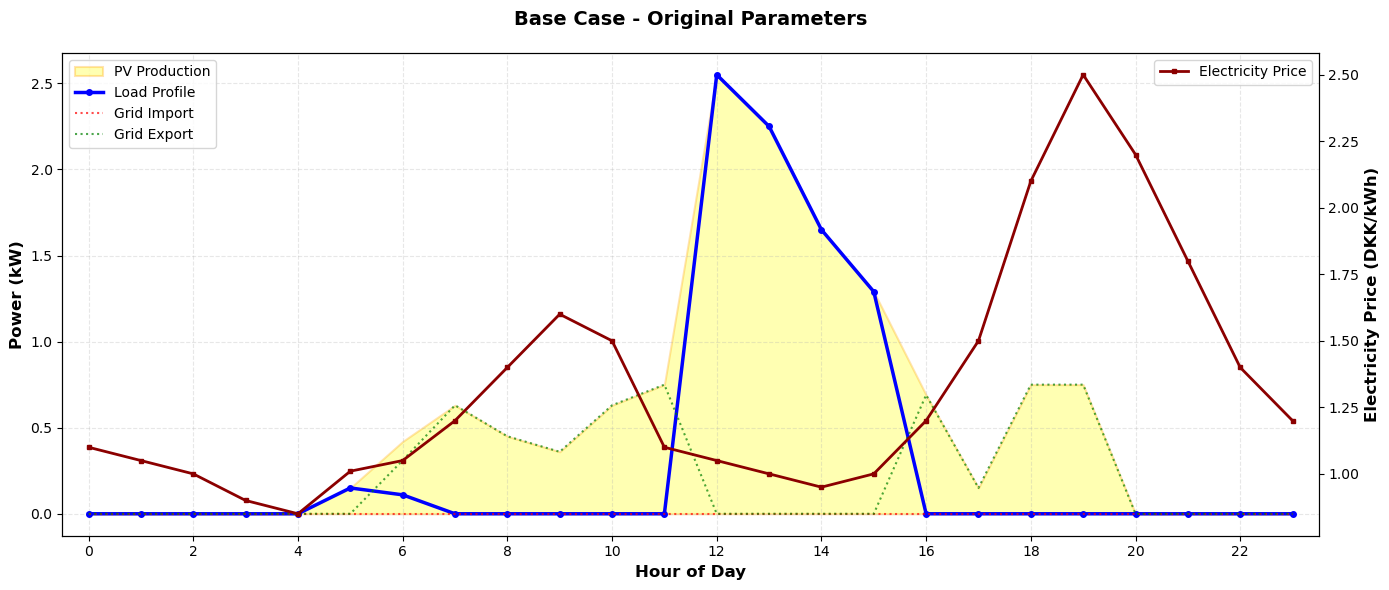

In [21]:
# Visualize Base Case
# Shows optimal energy scheduling under original parameters
plot_scenario_results(base_case_results, title="Base Case - Original Parameters")

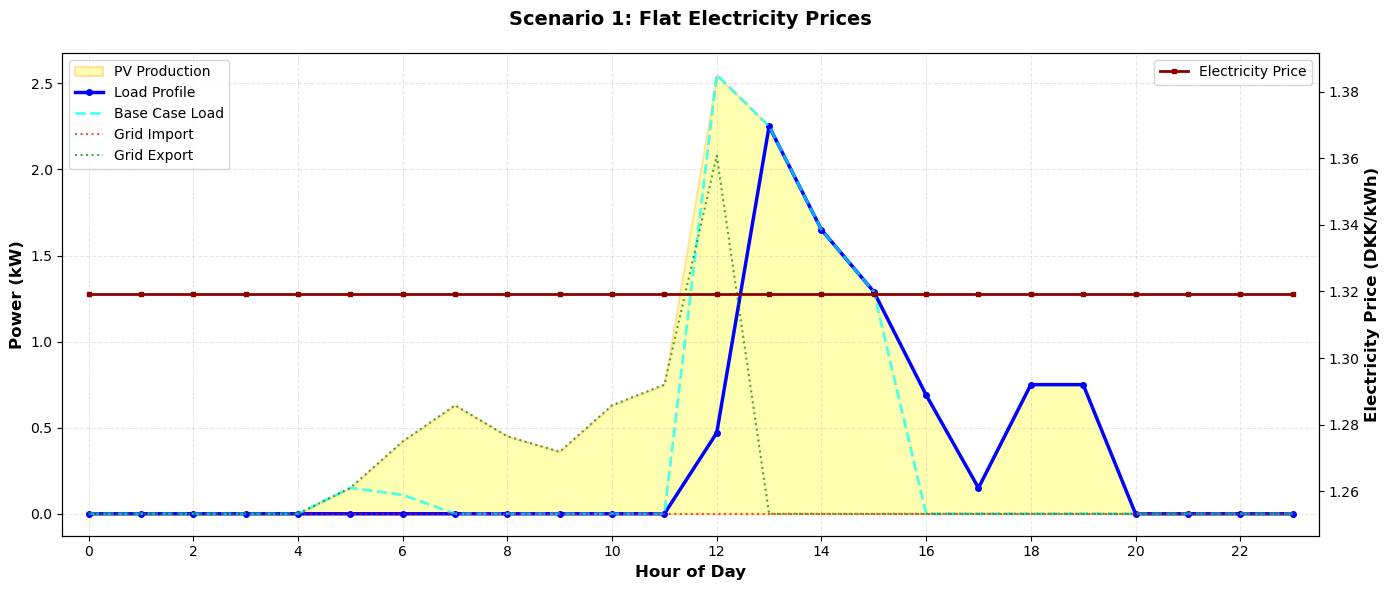

In [22]:
# Visualize Scenario 1: Flat Electricity Prices
# Compare load profile with and without price variation
plot_scenario_results(results_scenario1, base_results=base_case_results, 
                     title="Scenario 1: Flat Electricity Prices")

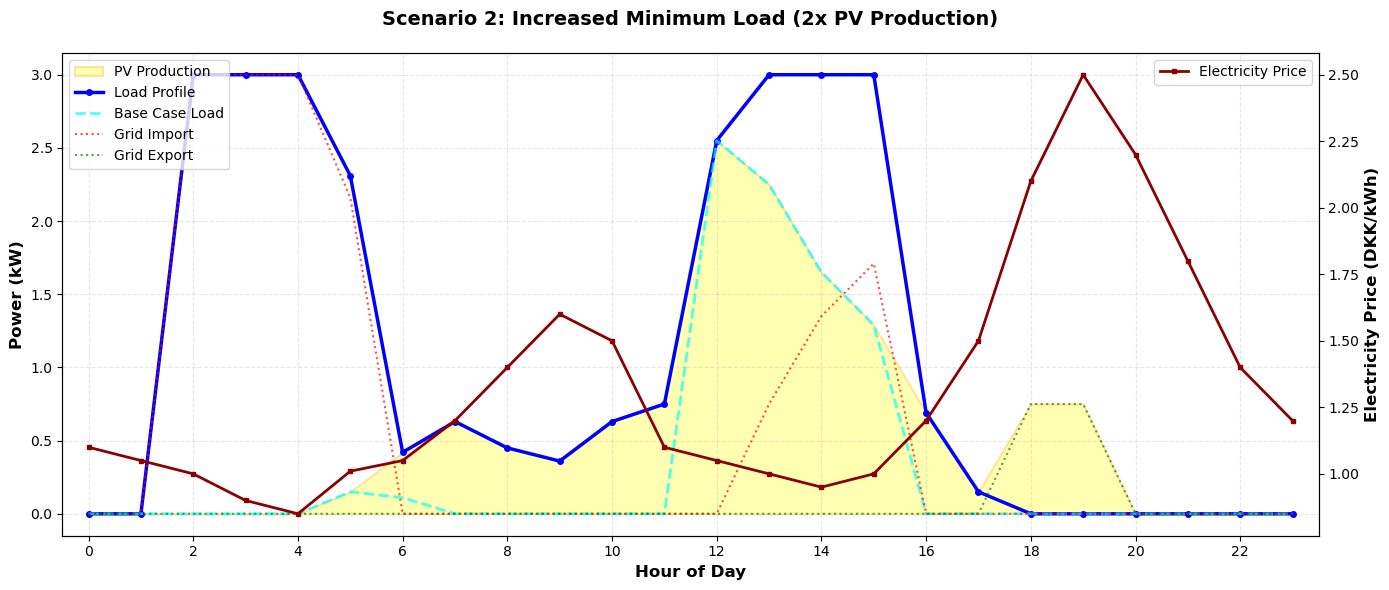

In [23]:
# Visualize Scenario 2: Increased Minimum Load
# Shows grid import behavior when demand exceeds PV capacity
plot_scenario_results(results_scenario2, base_results=base_case_results, 
                     title="Scenario 2: Increased Minimum Load (2x PV Production)")

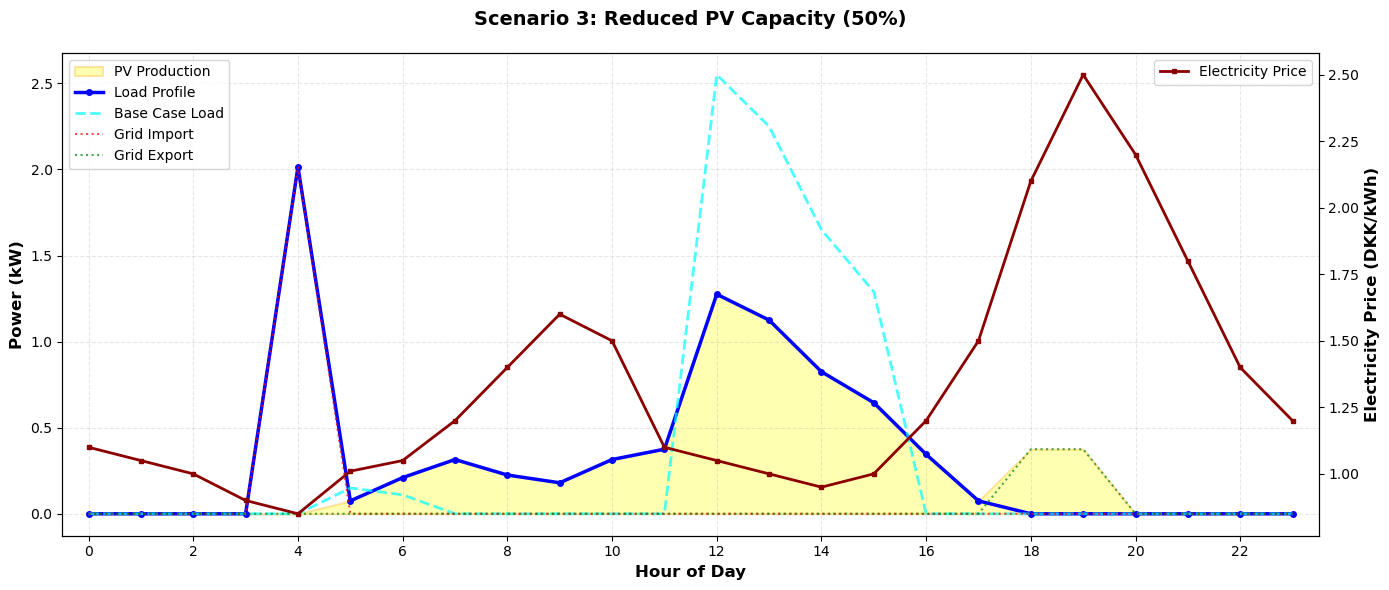

In [24]:
# Visualize Scenario 3: Reduced PV Capacity
# Shows impact of smaller PV system on grid dependency
plot_scenario_results(results_scenario4, base_results=base_case_results, 
                     title="Scenario 3: Reduced PV Capacity (50%)")

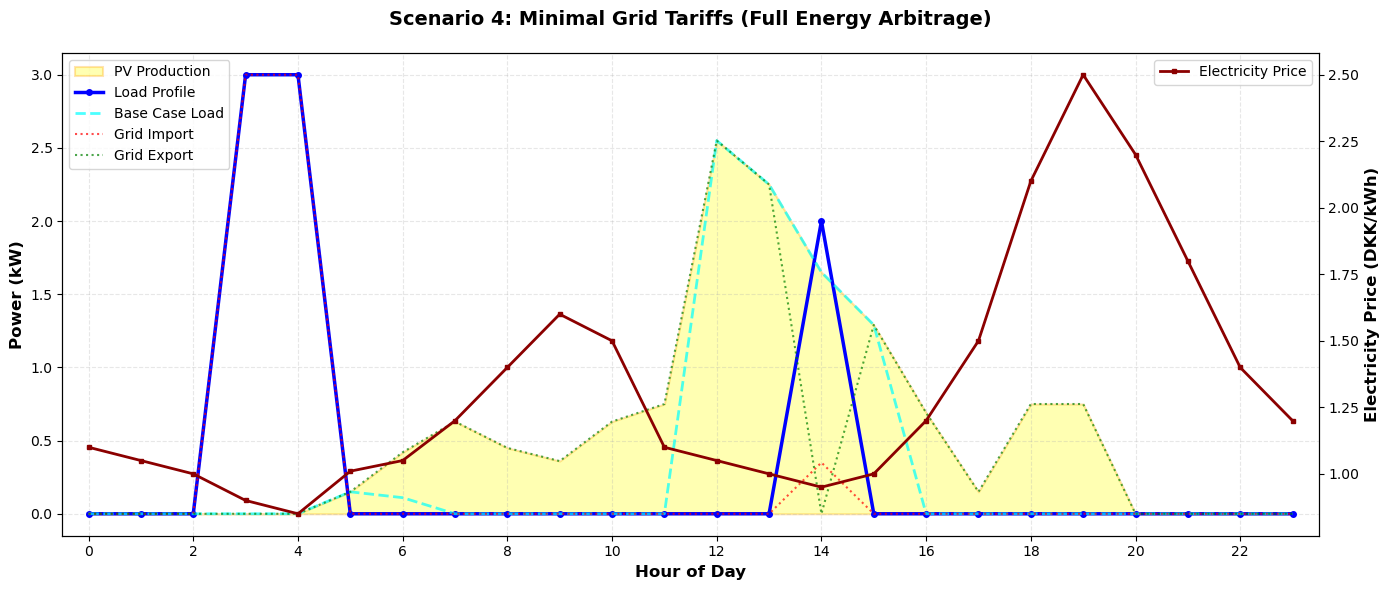

In [25]:
# Visualize Scenario 4: Minimal Grid Tariffs
# Demonstrates energy arbitrage behavior when grid fees are nearly zero
plot_scenario_results(results_scenario5, base_results=base_case_results, 
                     title="Scenario 4: Minimal Grid Tariffs (Full Energy Arbitrage)")

## Save All Plots

Save all generated plots to the Plots folder for documentation and reporting.

Saving plots to: ./Plots/Scenarios a)/
Saved: ./Plots/Scenarios a)/base_case.png
Saved: ./Plots/Scenarios a)/base_case.png


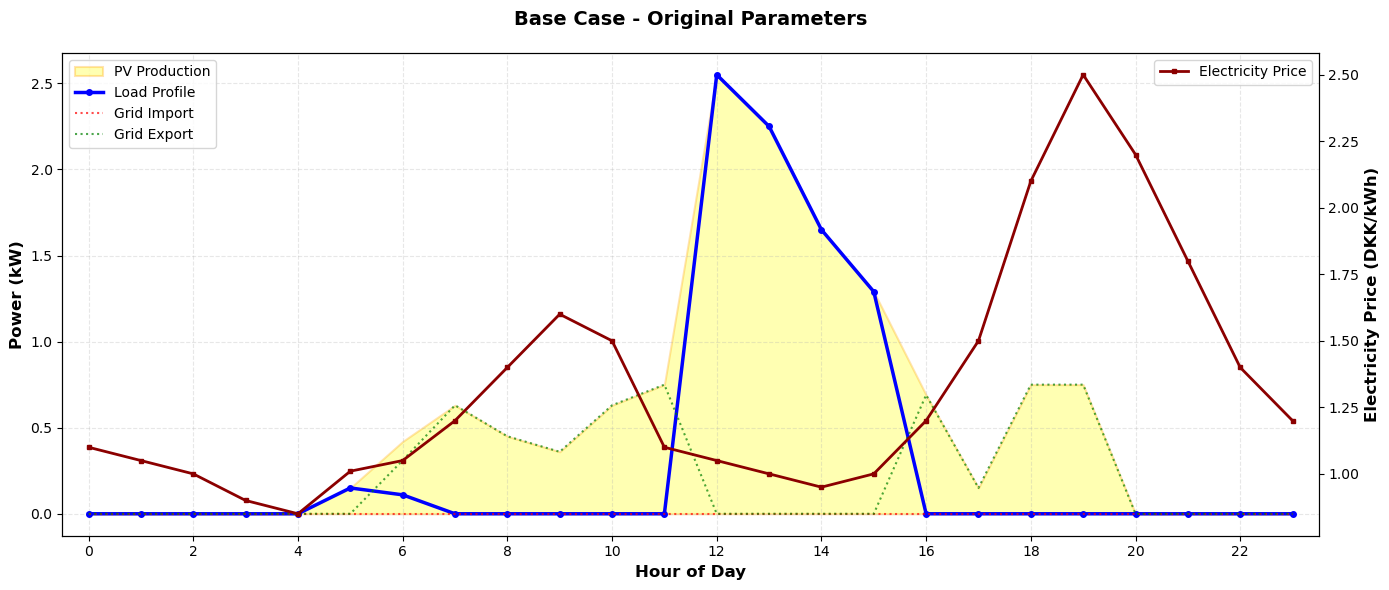

Saved: ./Plots/Scenarios a)/scenario_1_flat_prices.png


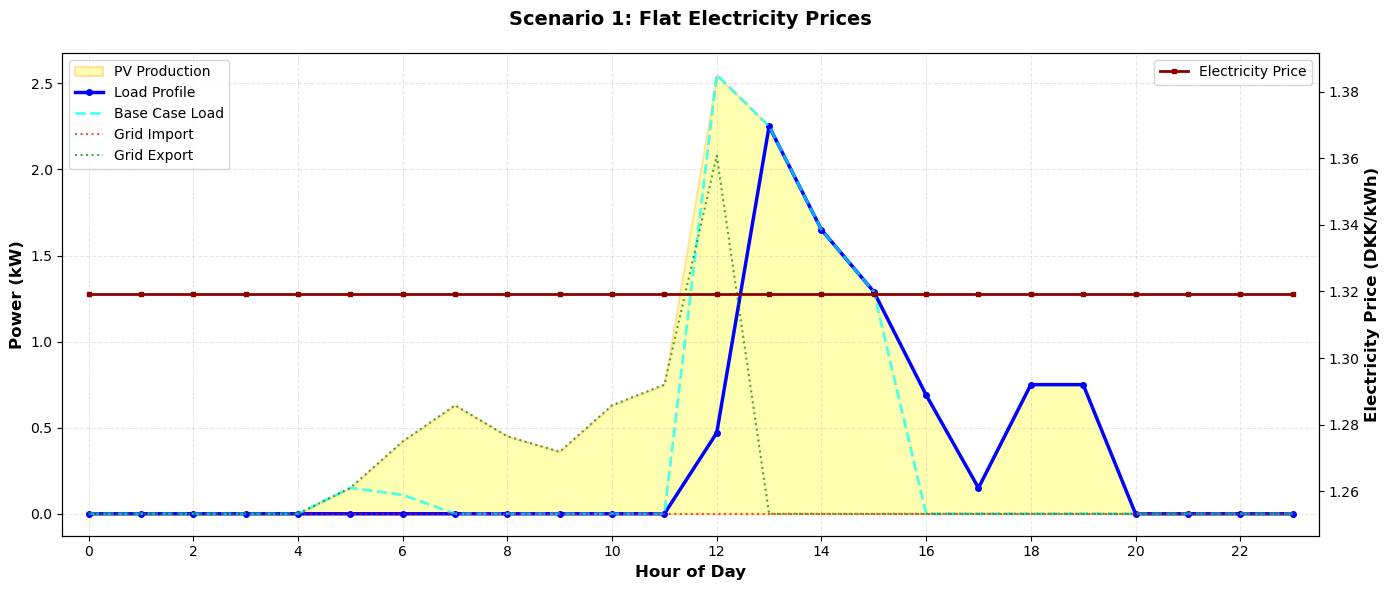

Saved: ./Plots/Scenarios a)/scenario_2_increased_load.png


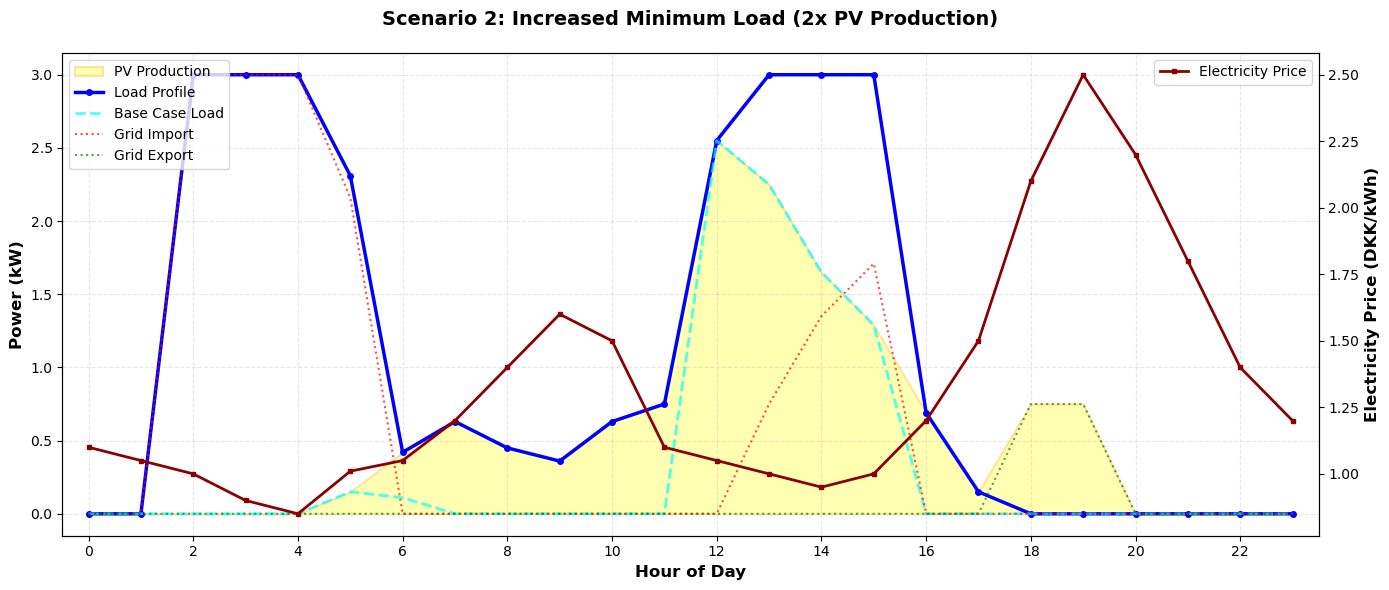

Saved: ./Plots/Scenarios a)/scenario_3_reduced_pv.png


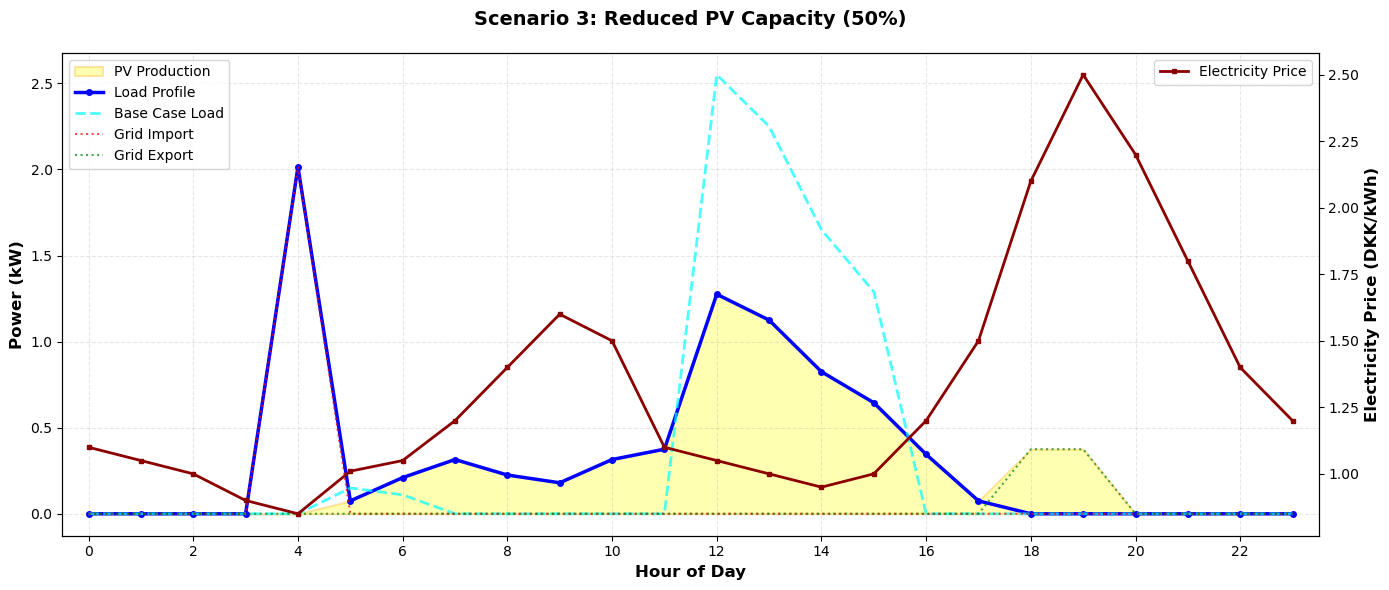

Saved: ./Plots/Scenarios a)/scenario_4_minimal_tariffs.png


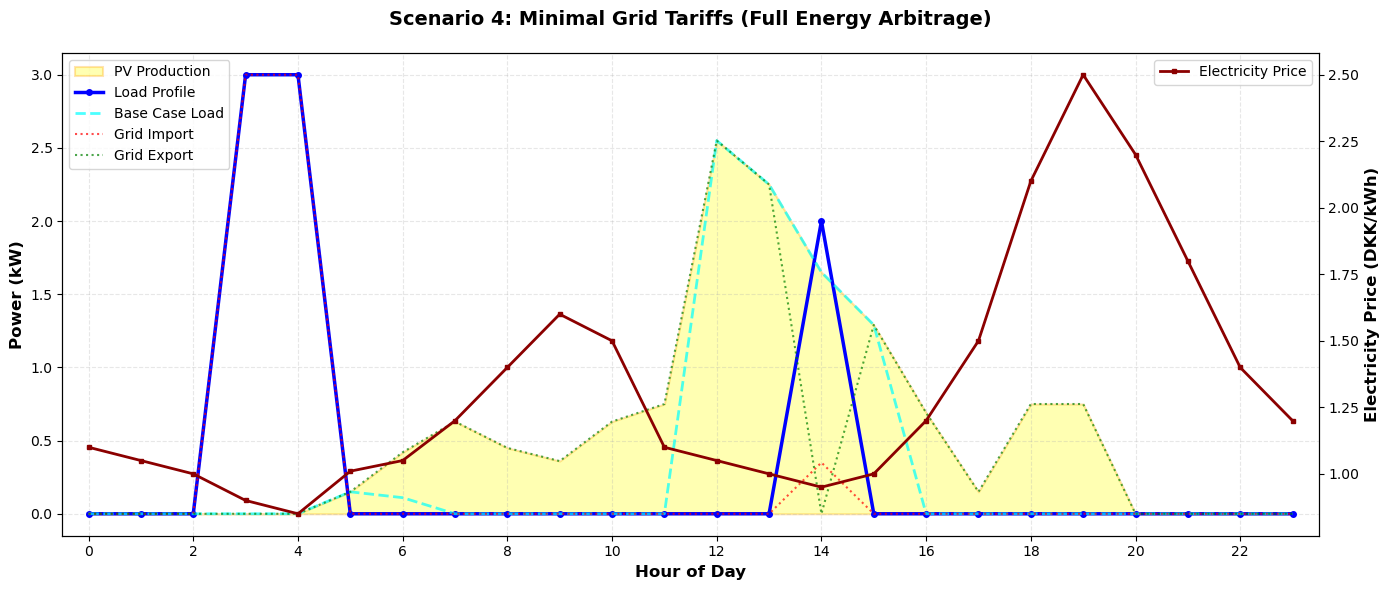

All plots saved successfully!


In [26]:
# Save all plots to the Plots folder for documentation and reporting
# Creates high-resolution PNG files for each scenario
output_folder = './Plots/Scenarios a)/'

print(f"Saving plots to: {output_folder}")
print("="*80)

# Save Base Case
plot_scenario_results(base_case_results, 
                     title="Base Case - Original Parameters",
                     save_path=f"{output_folder}base_case.png")

# Save Scenario 1: Flat Prices
plot_scenario_results(results_scenario1, base_results=base_case_results,
                     title="Scenario 1: Flat Electricity Prices",
                     save_path=f"{output_folder}scenario_1_flat_prices.png")

# Save Scenario 2: Increased Load
plot_scenario_results(results_scenario2, base_results=base_case_results,
                     title="Scenario 2: Increased Minimum Load (2x PV Production)",
                     save_path=f"{output_folder}scenario_2_increased_load.png")

# Save Scenario 3: Reduced PV
plot_scenario_results(results_scenario4, base_results=base_case_results,
                     title="Scenario 3: Reduced PV Capacity (50%)",
                     save_path=f"{output_folder}scenario_3_reduced_pv.png")

# Save Scenario 4: Minimal Tariffs
plot_scenario_results(results_scenario5, base_results=base_case_results,
                     title="Scenario 4: Minimal Grid Tariffs (Full Energy Arbitrage)",
                     save_path=f"{output_folder}scenario_4_minimal_tariffs.png")

print("="*80)
print("All plots saved successfully!")